## 0.  Import Dependencies

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

In [2]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 1. Load Dataset

Link Dataset: [Link Dataset](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews/data)

### Import Dataset

In [4]:
# df = pd.read_csv('dataset/IMDB/IMDB Dataset.csv', sep=',', encoding='utf-8')
df = pd.read_csv('/content/drive/MyDrive/UNIVERSITAS TELKOM S2/SEMESTER 3/DAMIN/UTS/dataset/IMDB/IMDB Dataset.csv', sep=',', encoding='utf-8')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


### Check Missing Values

In [5]:
# check for missing values
df.isnull().sum()

review       0
sentiment    0
dtype: int64

### Check Data Distribution

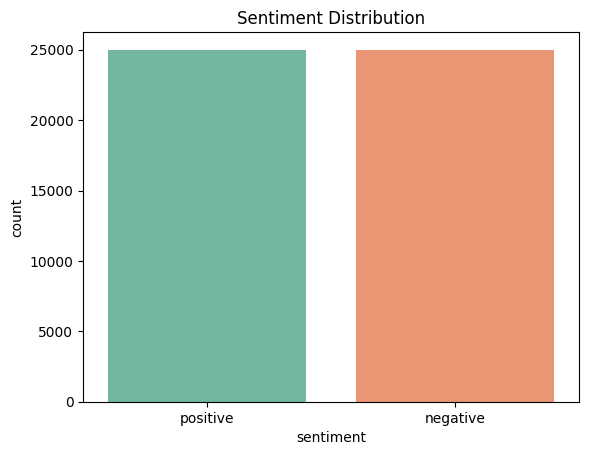

sentiment
positive    25000
negative    25000
Name: count, dtype: int64


In [6]:
# Check Sentiment Distribution
sns.countplot(x='sentiment', data=df, palette='Set2', hue='sentiment',  legend=False)
plt.title('Sentiment Distribution')
plt.show()

print(df['sentiment'].value_counts())

## 2. Cleaning & Preporcess the Data

### Cleaning Data

In [7]:
# Load English stopwords
stop_words = set(stopwords.words('english'))

# Load & Convert contractions dictionary to a more usable format
# contraction_df = pd.read_csv('dataset/IMDB/contractions.csv')
contraction_df = pd.read_csv('/content/drive/MyDrive/UNIVERSITAS TELKOM S2/SEMESTER 3/DAMIN/UTS/dataset/IMDB/contractions.csv')
contractions_map = dict(zip(contraction_df['Contraction'].str.lower(), contraction_df['Meaning'].str.lower()))

In [8]:
# Define a function for text cleaning
def clean_text(text):
    # Convert text to lowercase
    text = text.lower()

    # Remove HTML tags
    text = re.sub(r'<.*?>', '', text)

    # Remove emojis
    # Remove non-alphanumeric characters (keeping whitespace and commas for contraction replacement)
    text = re.sub(r'[^\w\s]', '', text)

    # Remove numbers
    text = re.sub(r'\d+', '', text)

    # Replace contractions
    text_split = text.split()
    text_split = [contractions_map.get(word, word) for word in text_split]
    text = ' '.join(text_split)

    # Remove punctuation
    text = re.sub(r'[\.,!?;]', '', text)

    # Remove stopwords
    text = ' '.join([word for word in text.split() if word not in stop_words])

    return text

# Apply the cleaning function to the review column
df['processed_review'] = df['review'].apply(clean_text)

In [9]:
# Mapping 'positive' to 1 and 'negative' to 0
df['sentiment'] = df['sentiment'].map({'positive': 1, 'negative': 0})

#### Stemming

In [10]:
df_stemming = df.copy()

In [11]:
def stem_text(text):
    # Tokenization
    tokens = word_tokenize(text)

    # Stemming
    stemmer = PorterStemmer()
    stemmed_text = ' '.join([stemmer.stem(token) for token in tokens])
    return stemmed_text

# Example of applying the function
df_stemming['processed_review'] = df_stemming['processed_review'].apply(stem_text)

#### Lemmatization

In [12]:
df_lemmatization = df.copy()

In [13]:
def lemmatize_text(text):
    # Tokenization
    tokens = nltk.word_tokenize(text)

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmatized_text = ' '.join([lemmatizer.lemmatize(token) for token in tokens])
    return lemmatized_text

# Example of applying the function
df_lemmatization['processed_review'] = df_lemmatization['processed_review'].apply(lemmatize_text)

#### Inspect Dataset

In [14]:
list(df['processed_review'][:5])

['one reviewers mentioned watching oz episode youll hooked right exactly happened methe first thing struck oz brutality unflinching scenes violence set right word go trust show faint hearted timid show pulls punches regards drugs sex violence hardcore classic use wordit called oz nickname given oswald maximum security state penitentary focuses mainly emerald city experimental section prison cells glass fronts face inwards privacy high agenda em city home manyaryans muslims gangstas latinos christians italians irish moreso scuffles death stares dodgy dealings shady agreements never far awayi would say main appeal show due fact goes shows wouldnt dare forget pretty pictures painted mainstream audiences forget charm forget romanceoz doesnt mess around first episode ever saw struck nasty surreal couldnt say ready watched developed taste oz got accustomed high levels graphic violence violence injustice crooked guards wholl sold nickel inmates wholl kill order get away well mannered middle c

In [15]:
list(df_lemmatization['processed_review'][:5])

['one reviewer mentioned watching oz episode youll hooked right exactly happened methe first thing struck oz brutality unflinching scene violence set right word go trust show faint hearted timid show pull punch regard drug sex violence hardcore classic use wordit called oz nickname given oswald maximum security state penitentary focus mainly emerald city experimental section prison cell glass front face inwards privacy high agenda em city home manyaryans muslim gangsta latino christian italian irish moreso scuffle death stare dodgy dealing shady agreement never far awayi would say main appeal show due fact go show wouldnt dare forget pretty picture painted mainstream audience forget charm forget romanceoz doesnt mess around first episode ever saw struck nasty surreal couldnt say ready watched developed taste oz got accustomed high level graphic violence violence injustice crooked guard wholl sold nickel inmate wholl kill order get away well mannered middle class inmate turned prison bi

In [16]:
list(df_stemming['processed_review'][:5])

['one review mention watch oz episod youll hook right exactli happen meth first thing struck oz brutal unflinch scene violenc set right word go trust show faint heart timid show pull punch regard drug sex violenc hardcor classic use wordit call oz nicknam given oswald maximum secur state penitentari focus mainli emerald citi experiment section prison cell glass front face inward privaci high agenda em citi home manyaryan muslim gangsta latino christian italian irish moreso scuffl death stare dodgi deal shadi agreement never far awayi would say main appeal show due fact goe show wouldnt dare forget pretti pictur paint mainstream audienc forget charm forget romanceoz doesnt mess around first episod ever saw struck nasti surreal couldnt say readi watch develop tast oz got accustom high level graphic violenc violenc injustic crook guard wholl sold nickel inmat wholl kill order get away well manner middl class inmat turn prison bitch due lack street skill prison experi watch oz may becom co

## 3. Some Visulization & Statistical Analysis


### Review Length Analysis
- The reviews have a wide range of lengths, from 32 to 13,704 characters.
- The average review length is about 1,309 characters, with a standard deviation of 989 caracters.
- The median length of reviews is 970 characters, indicating that half of the reviews are shorter than this and half are longer.

In [17]:
# # Calculate the length of each review (character count)
# df['review_length'] = df['review'].apply(len)

# # Calculate the length of reviews for each sentiment (word count)
# df['word_length'] = df['review'].apply(lambda x: len(x.split()))

# # Descriptive statistics for review lengths
# review_length_stats = df['review_length'].describe()
# review_length_stats

### Bar Plot 20 Most Common Words

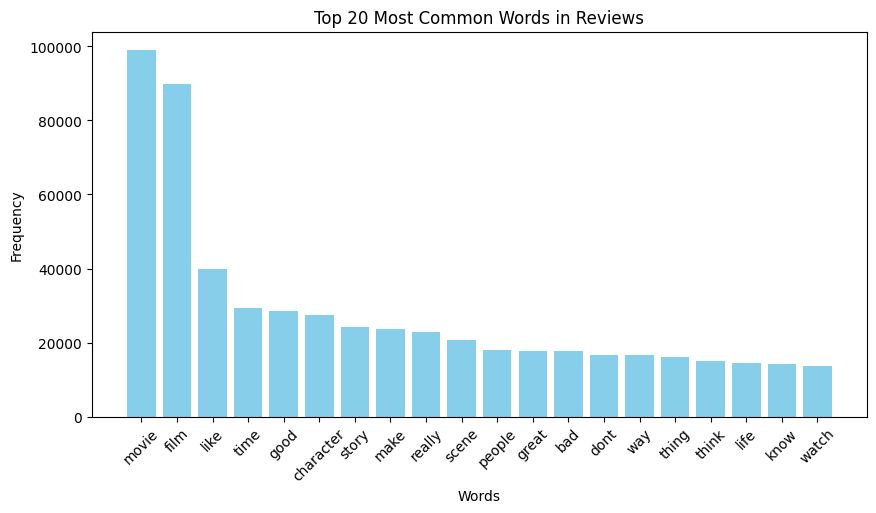

In [18]:
# Create a CountVectorizer to count word frequencies, limiting to the top 20 words
vectorizer = CountVectorizer(stop_words='english', max_features=20)

# Fit and transform the data
word_counts = vectorizer.fit_transform(df_lemmatization['processed_review'])

# Sum up the counts of each vocabulary word
sum_words = word_counts.sum(axis=0)

# Connecting words with their counts
words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

# Prepare data for plotting
words, counts = zip(*words_freq)

# Plotting
plt.figure(figsize=(10, 5))
plt.bar(words, counts, color='skyblue')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 20 Most Common Words in Reviews')
plt.xticks(rotation=45)
plt.show()


### Word Cloud of Most common words in Positive and Negative Review

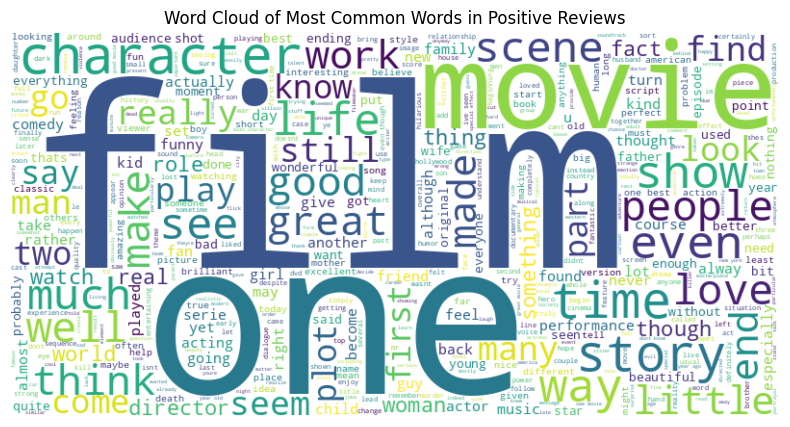

In [19]:
# Generate Word cloud for positive reviews
positive_reviews = df_lemmatization[df_lemmatization['sentiment'] == 1]
positive_text = list(positive_reviews['processed_review'])
positive_wordcloud = WordCloud(max_words = 1000, width=800, height=400, background_color='white').generate(' '.join(positive_text))

# Displaying the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Most Common Words in Positive Reviews')
plt.show()

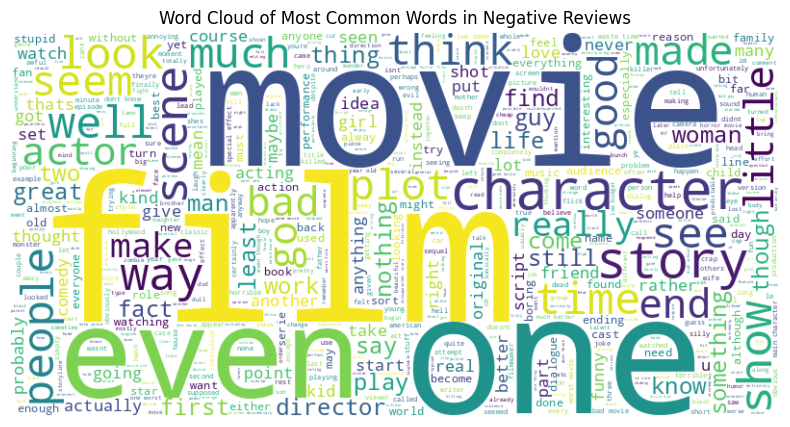

In [20]:
# Generate Word cloud for negative reviews
negative_reviews = df_lemmatization[df_lemmatization['sentiment'] == 0]
negative_text = list(negative_reviews['processed_review'])
negative_wordcloud = WordCloud(max_words = 1000, width=800, height=400, background_color='white').generate(' '.join(negative_text))

# Displaying the word cloud
plt.figure(figsize=(10, 5))
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Most Common Words in Negative Reviews')
plt.show()

## Model

### Logistic Regression

#### Not Using Stemming & Lemmatization

In [21]:
# Prepare feature matrix X and target vector y
X = df['processed_review']
y = df['sentiment']

# Vectorization of the text data
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the logistic regression model
logreg_model = LogisticRegression()
logreg_model.fit(X_train, y_train)

# Predictions and evaluation
logreg_predictions = logreg_model.predict(X_test)
logreg_accuracy = accuracy_score(y_test, logreg_predictions)
logreg_precision = precision_score(y_test, logreg_predictions)
logreg_recall = recall_score(y_test, logreg_predictions)
logreg_f1 = f1_score(y_test, logreg_predictions)

In [22]:
# Print the evaluation metrics
print('Not Using Stemming & Lemmatization')
print("Accuracy:", logreg_accuracy)
print("Precision:", logreg_precision)
print("Recall:", logreg_recall)
print("F1 Score:", logreg_f1)

Not Using Stemming & Lemmatization
Accuracy: 0.8949
Precision: 0.8862843858969391
Recall: 0.9079182377455844
F1 Score: 0.8969708852073326


In [23]:
print(classification_report(y_test, logreg_predictions))

              precision    recall  f1-score   support

           0       0.90      0.88      0.89      4961
           1       0.89      0.91      0.90      5039

    accuracy                           0.89     10000
   macro avg       0.90      0.89      0.89     10000
weighted avg       0.90      0.89      0.89     10000



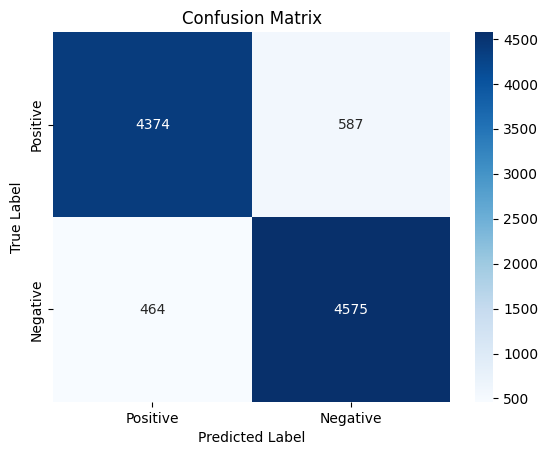

In [24]:
# Confusion matrix
cm = confusion_matrix(y_test, logreg_predictions)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Positive', 'Negative'], yticklabels=['Positive', 'Negative'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

#### Using Stemming

In [25]:
# Prepare feature matrix X and target vector y
X = df_stemming['processed_review']
y = df_stemming['sentiment']

# Vectorization of the text data
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the logistic regression model
logreg_stem_model = LogisticRegression()
logreg_stem_model.fit(X_train, y_train)

# Predictions and evaluation
logreg_stem_predictions = logreg_stem_model.predict(X_test)
logreg_stem_accuracy = accuracy_score(y_test, logreg_stem_predictions)
logreg_stem_precision = precision_score(y_test, logreg_stem_predictions)
logreg_stem_recall = recall_score(y_test, logreg_stem_predictions)
logreg_stem_f1 = f1_score(y_test, logreg_stem_predictions)

In [26]:
# Print the evaluation metrics
print('Using Stemming')
print("Accuracy:", logreg_stem_accuracy)
print("Precision:", logreg_stem_precision)
print("Recall:", logreg_stem_recall)
print("F1 Score:", logreg_stem_f1)

Using Stemming
Accuracy: 0.8892
Precision: 0.8792205286513602
Recall: 0.9043461004167493
F1 Score: 0.891606339268245


In [27]:
print(classification_report(y_test, logreg_stem_predictions))

              precision    recall  f1-score   support

           0       0.90      0.87      0.89      4961
           1       0.88      0.90      0.89      5039

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



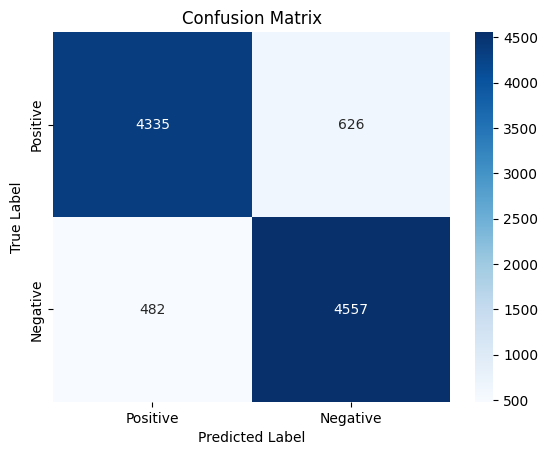

In [28]:
# Confusion matrix
cm = confusion_matrix(y_test, logreg_stem_predictions)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Positive', 'Negative'], yticklabels=['Positive', 'Negative'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

#### Using Lemmatization

In [29]:
# Prepare feature matrix X and target vector y
X = df_lemmatization['processed_review']
y = df_lemmatization['sentiment']

# Vectorization of the text data
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the logistic regression model
logreg_lemma_model = LogisticRegression()
logreg_lemma_model.fit(X_train, y_train)

# Predictions and evaluation
logreg_lemma_predictions = logreg_lemma_model.predict(X_test)
logreg_lemma_accuracy = accuracy_score(y_test, logreg_lemma_predictions)
logreg_lemma_precision = precision_score(y_test, logreg_lemma_predictions)
logreg_lemma_recall = recall_score(y_test, logreg_lemma_predictions)
logreg_lemma_f1 = f1_score(y_test, logreg_lemma_predictions)

In [30]:
# Print the evaluation metrics
print('Using Lemmatization')
print("Accuracy:", logreg_lemma_accuracy)
print("Precision:", logreg_lemma_precision)
print("Recall:", logreg_lemma_recall)
print("F1 Score:", logreg_lemma_f1)

Using Lemmatization
Accuracy: 0.8941
Precision: 0.8852109949670925
Recall: 0.9075213335979361
F1 Score: 0.8962273395394414


In [31]:
print(classification_report(y_test, logreg_lemma_predictions))

              precision    recall  f1-score   support

           0       0.90      0.88      0.89      4961
           1       0.89      0.91      0.90      5039

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000



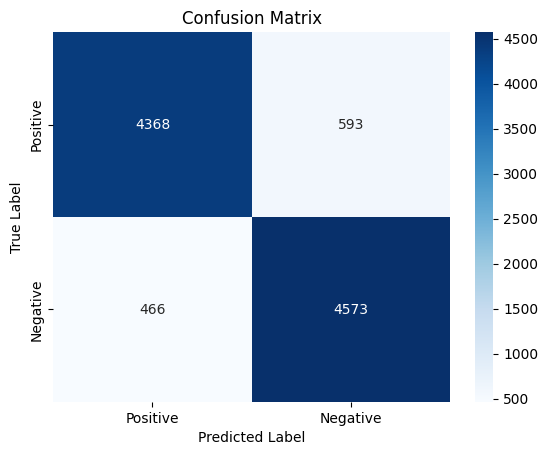

In [32]:
# Confusion matrix
cm = confusion_matrix(y_test, logreg_lemma_predictions)

# Plot the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Positive', 'Negative'], yticklabels=['Positive', 'Negative'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

### SVM

#### Not Using Stemming & Lemmatization

In [33]:
# Prepare feature matrix X and target vector y
X = df['processed_review']
y = df['sentiment']

# Vectorization of the text data
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# SVM Model
svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)

# Predictions and evaluation
svm_predictions = svm_model.predict(X_test)
svm_accuracy = accuracy_score(y_test, svm_predictions)
svm_precision = precision_score(y_test, svm_predictions)
svm_recall = recall_score(y_test, svm_predictions)
svm_f1 = f1_score(y_test, svm_predictions)

In [34]:
# Print the evaluation metrics
print('SVM Evaluation')
print("Accuracy:", svm_accuracy)
print("Precision:", svm_precision)
print("Recall:", svm_recall)
print("F1 Score:", svm_f1)

SVM Evaluation
Accuracy: 0.8989
Precision: 0.8915241057542769
Recall: 0.9101012105576504
F1 Score: 0.9007168810763035


In [35]:
print("SVM Classification Report:\n", classification_report(y_test, svm_predictions))

SVM Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.89      0.90      4961
           1       0.89      0.91      0.90      5039

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



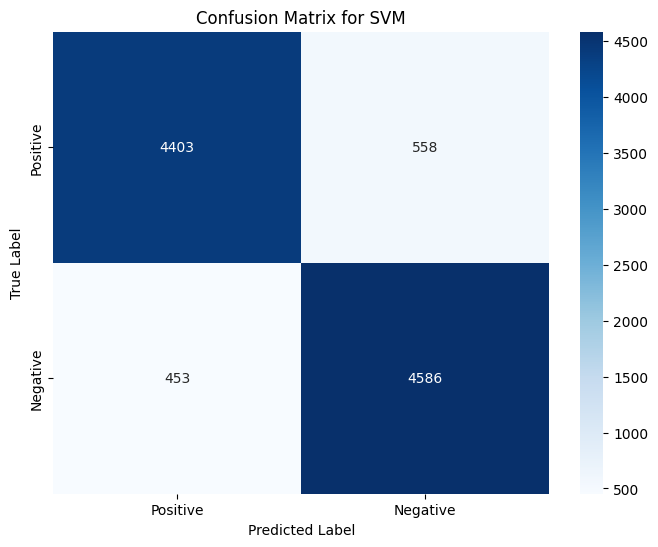

In [36]:
# Confusion matrix for SVM
svm_conf_matrix = confusion_matrix(y_test, svm_predictions)
plt.figure(figsize=(8,6))
sns.heatmap(svm_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Positive', 'Negative'], yticklabels=['Positive', 'Negative'])
plt.title('Confusion Matrix for SVM')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

#### Using Stemming

In [37]:
# Prepare feature matrix X and target vector y
X = df_stemming['processed_review']
y = df_stemming['sentiment']

# Vectorization of the text data
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# SVM Model
svm_stem_model = SVC(kernel='linear')
svm_stem_model.fit(X_train, y_train)

# Predictions and evaluation
svm_stem_predictions = svm_stem_model.predict(X_test)
svm_stem_accuracy = accuracy_score(y_test, svm_stem_predictions)
svm_stem_precision = precision_score(y_test, svm_stem_predictions)
svm_stem_recall = recall_score(y_test, svm_stem_predictions)
svm_stem_f1 = f1_score(y_test, svm_stem_predictions)

In [38]:
# Print the evaluation metrics
print('SVM Evaluation')
print("Accuracy:", svm_stem_accuracy)
print("Precision:", svm_stem_precision)
print("Recall:", svm_stem_recall)
print("F1 Score:", svm_stem_f1)

SVM Evaluation
Accuracy: 0.8951
Precision: 0.8866279069767442
Recall: 0.9079182377455844
F1 Score: 0.8971467790959897


In [39]:
print("SVM Classification Report:\n", classification_report(y_test, svm_stem_predictions))

SVM Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.88      0.89      4961
           1       0.89      0.91      0.90      5039

    accuracy                           0.90     10000
   macro avg       0.90      0.89      0.90     10000
weighted avg       0.90      0.90      0.90     10000



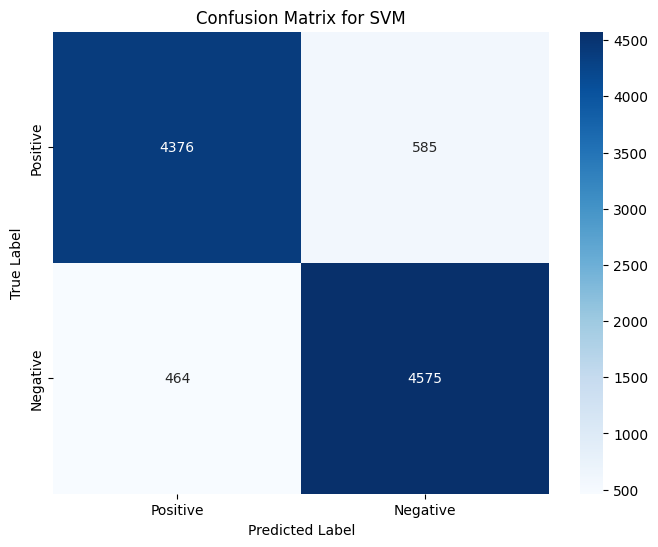

In [40]:
# Confusion matrix for SVM
svm_conf_matrix = confusion_matrix(y_test, svm_stem_predictions)
plt.figure(figsize=(8,6))
sns.heatmap(svm_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Positive', 'Negative'], yticklabels=['Positive', 'Negative'])
plt.title('Confusion Matrix for SVM')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

#### Using Lemmatization

In [41]:
# Prepare feature matrix X and target vector y
X = df_lemmatization['processed_review']
y = df_lemmatization['sentiment']

# Vectorization of the text data
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# SVM Model
svm_lemma_model = SVC(kernel='linear')
svm_lemma_model.fit(X_train, y_train)

# Predictions and evaluation
svm_lemma_predictions = svm_lemma_model.predict(X_test)
svm_lemma_accuracy = accuracy_score(y_test, svm_lemma_predictions)
svm_lemma_precision = precision_score(y_test, svm_lemma_predictions)
svm_lemma_recall = recall_score(y_test, svm_lemma_predictions)
svm_lemma_f1 = f1_score(y_test, svm_lemma_predictions)

In [42]:
# Print the evaluation metrics
print('SVM Evaluation')
print("Accuracy:", svm_lemma_accuracy)
print("Precision:", svm_lemma_precision)
print("Recall:", svm_lemma_recall)
print("F1 Score:", svm_lemma_f1)

SVM Evaluation
Accuracy: 0.8972
Precision: 0.8917757374487204
Recall: 0.9059337170073427
F1 Score: 0.8987989761764126


In [43]:
print("SVM Classification Report:\n", classification_report(y_test, svm_lemma_predictions))

SVM Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.89      0.90      4961
           1       0.89      0.91      0.90      5039

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



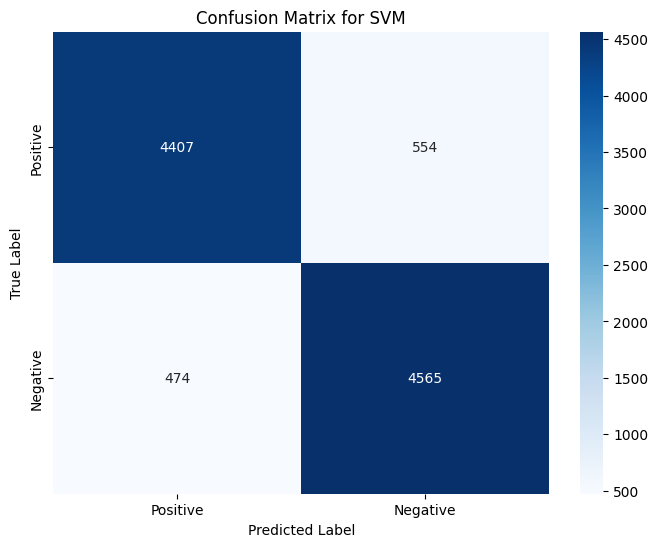

In [44]:
# Confusion matrix for SVM
svm_conf_matrix = confusion_matrix(y_test, svm_lemma_predictions)
plt.figure(figsize=(8,6))
sns.heatmap(svm_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Positive', 'Negative'], yticklabels=['Positive', 'Negative'])
plt.title('Confusion Matrix for SVM')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

### Naive Bayes

#### Not Using Stemming & Lemmatization

In [45]:
# Prepare feature matrix X and target vector y
X = df['processed_review']
y = df['sentiment']

# Vectorization of the text data
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# SVM Model
nb_model = MultinomialNB()
nb_model.fit(X_train, y_train)

# Predictions and evaluation
nb_predictions = nb_model.predict(X_test)
nb_accuracy = accuracy_score(y_test, nb_predictions)
nb_precision = precision_score(y_test, nb_predictions)
nb_recall = recall_score(y_test, nb_predictions)
nb_f1 = f1_score(y_test, nb_predictions)

In [46]:
# Print the evaluation metrics
print('NB Evaluation')
print("Accuracy:", nb_accuracy)
print("Precision:", nb_precision)
print("Recall:", nb_recall)
print("F1 Score:", nb_f1)

NB Evaluation
Accuracy: 0.8681
Precision: 0.8800572129137719
Recall: 0.8547330819607065
F1 Score: 0.8672103090707742


In [47]:
print("Naive Bayes Classification Report:\n", classification_report(y_test, nb_predictions))

Naive Bayes Classification Report:
               precision    recall  f1-score   support

           0       0.86      0.88      0.87      4961
           1       0.88      0.85      0.87      5039

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



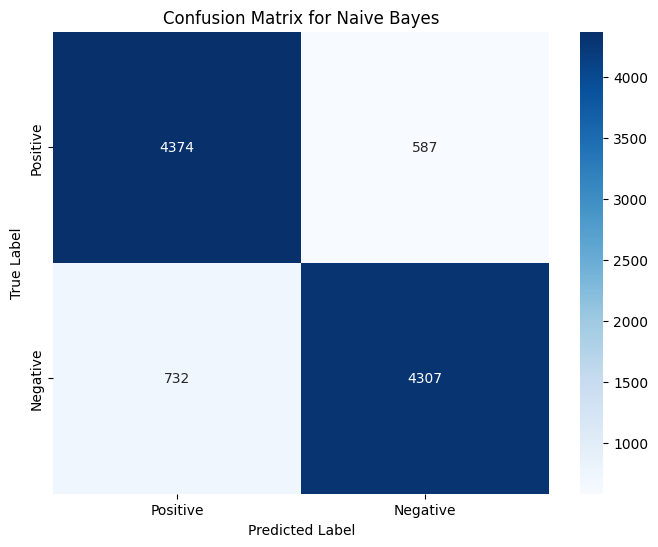

In [48]:
# Confusion matrix for Naive Bayes
nb_conf_matrix = confusion_matrix(y_test, nb_predictions)
plt.figure(figsize=(8,6))
sns.heatmap(nb_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Positive', 'Negative'], yticklabels=['Positive', 'Negative'])
plt.title('Confusion Matrix for Naive Bayes')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

#### Using Stemming

In [49]:
# Prepare feature matrix X and target vector y
X = df_stemming['processed_review']
y = df_stemming['sentiment']

# Vectorization of the text data
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# SVM Model
nb_stem_model = MultinomialNB()
nb_stem_model.fit(X_train, y_train)

# Predictions and evaluation
nb_stem_predictions = nb_stem_model.predict(X_test)
nb_stem_accuracy = accuracy_score(y_test, nb_stem_predictions)
nb_stem_precision = precision_score(y_test, nb_stem_predictions)
nb_stem_recall = recall_score(y_test, nb_stem_predictions)
nb_stem_f1 = f1_score(y_test, nb_stem_predictions)

In [50]:
# Print the evaluation metrics
print('NB with Stemming Evaluation')
print("Accuracy:", nb_stem_accuracy)
print("Precision:", nb_stem_precision)
print("Recall:", nb_stem_recall)
print("F1 Score:", nb_stem_f1)

NB with Stemming Evaluation
Accuracy: 0.8611
Precision: 0.8712367778681855
Recall: 0.8499702321889264
F1 Score: 0.8604721245605224


In [51]:
print("Naive Bayes Classification Report:\n", classification_report(y_test, nb_stem_predictions))

Naive Bayes Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.87      0.86      4961
           1       0.87      0.85      0.86      5039

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000



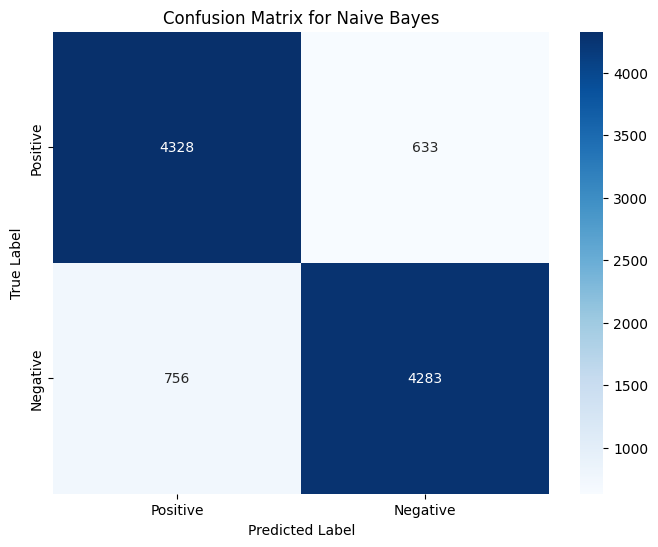

In [52]:
# Confusion matrix for Naive Bayes
nb_conf_matrix = confusion_matrix(y_test, nb_stem_predictions)
plt.figure(figsize=(8,6))
sns.heatmap(nb_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Positive', 'Negative'], yticklabels=['Positive', 'Negative'])
plt.title('Confusion Matrix for Naive Bayes')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

#### Using Lemmatization

In [53]:
# Prepare feature matrix X and target vector y
X = df_lemmatization['processed_review']
y = df_lemmatization['sentiment']

# Vectorization of the text data
tfidf = TfidfVectorizer()
X = tfidf.fit_transform(X)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# SVM Model
nb_lemma_model = MultinomialNB()
nb_lemma_model.fit(X_train, y_train)

# Predictions and evaluation
nb_lemma_predictions = nb_lemma_model.predict(X_test)
nb_lemma_accuracy = accuracy_score(y_test, nb_lemma_predictions)
nb_lemma_precision = precision_score(y_test, nb_lemma_predictions)
nb_lemma_recall = recall_score(y_test, nb_lemma_predictions)
nb_lemma_f1 = f1_score(y_test, nb_lemma_predictions)

In [54]:
# Print the evaluation metrics
print('NB with Lemmatization Evaluation')
print("Accuracy:", nb_lemma_accuracy)
print("Precision:", nb_lemma_precision)
print("Recall:", nb_lemma_recall)
print("F1 Score:", nb_lemma_f1)

NB with Lemmatization Evaluation
Accuracy: 0.8663
Precision: 0.878992628992629
Recall: 0.851954752927168
F1 Score: 0.8652625214148947


In [55]:
print("Naive Bayes Classification Report:\n", classification_report(y_test, nb_lemma_predictions))

Naive Bayes Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.88      0.87      4961
           1       0.88      0.85      0.87      5039

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000



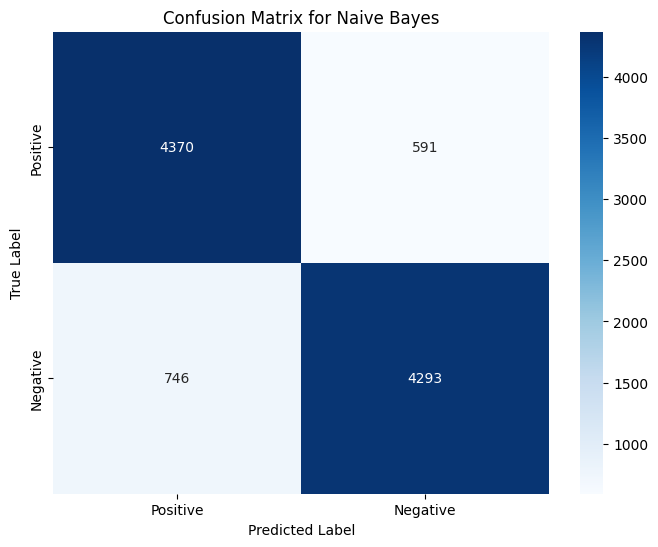

In [56]:
# Confusion matrix for Naive Bayes
nb_conf_matrix = confusion_matrix(y_test, nb_lemma_predictions)
plt.figure(figsize=(8,6))
sns.heatmap(nb_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Positive', 'Negative'], yticklabels=['Positive', 'Negative'])
plt.title('Confusion Matrix for Naive Bayes')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

### LSTM

#### Prepare Dataset

##### Word2Vec

In [22]:
from gensim.models import Word2Vec

# Prepare data for Word2Vec
sentences = [row.split() for row in df_lemmatization['processed_review']]
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=2, workers=4)

# Save the model for later use
word2vec_model.save("/content/drive/MyDrive/UNIVERSITAS TELKOM S2/SEMESTER 3/DAMIN/UTS/model/word2vec_imdb.model")

In [121]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence

import time
import json

In [23]:
class IMDBDataset(Dataset):
    def __init__(self, reviews, labels, word2vec):
        self.reviews = reviews
        self.labels = labels
        self.word2vec = word2vec

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, idx):
        # Convert words to their corresponding embeddings
        words = self.reviews[idx]
        embeddings = [self.word2vec.wv[word] for word in words if word in self.word2vec.wv]

        # Convert list of numpy arrays to a single numpy array before converting to tensor
        embeddings = np.array(embeddings, dtype=np.float32)

        embeddings = torch.tensor(embeddings, dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return embeddings, label

def collate_fn(batch):
    # Sort the batch in the descending order of sequence length
    batch.sort(key=lambda x: x[0].shape[0], reverse=True)
    sequences, labels = zip(*batch)
    # Pad the sequences to have the same length
    sequences_padded = pad_sequence(sequences, batch_first=True)
    labels = torch.stack(labels)
    return sequences_padded, labels

##### BILSTM MODEL

In [24]:
class BiLSTM(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, output_dim, num_layers):
        super(BiLSTM, self).__init__()
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def forward(self, x):
        # Computing the packed sequence of embeddings
        packed_output, (hidden, cell) = self.lstm(x)
        # Concatenate the final forward and backward hidden state
        hidden = torch.cat((hidden[-2,:,:], hidden[-1,:,:]), dim=1)
        out = self.fc(hidden)
        return torch.sigmoid(out)

# Hyperparameters
embedding_dim = 100  # As per Word2Vec setting
hidden_dim = 128
output_dim = 1
num_layers = 2

# Model instance
model = BiLSTM(embedding_dim, hidden_dim, output_dim, num_layers)

In [25]:
# Count the total number of parameters in the model
total_params = sum(p.numel() for p in model.parameters())
print("Total number of parameters:", total_params)

# Count the number of non-zero parameters
non_zero_params = sum(p.numel() for p in model.parameters() if p.requires_grad and torch.sum(p != 0).item() > 0)
print("Number of non-zero parameters:", non_zero_params)

# Calculate the percentage of parameters utilized
percent_utilized = (non_zero_params / total_params) * 100
print("Percentage of parameters utilized: {:.2f}%".format(percent_utilized))

Total number of parameters: 631041
Number of non-zero parameters: 631041
Percentage of parameters utilized: 100.00%


##### DATA LOADER

In [52]:
# Split data into training and testing sets
train_sentences, test_sentences, train_labels, test_labels = train_test_split(sentences, df_lemmatization['sentiment'].values, test_size=0.2, random_state=42)

# Create Datasets
train_dataset = IMDBDataset(train_sentences, train_labels, word2vec_model)
test_dataset = IMDBDataset(test_sentences, test_labels, word2vec_model)

#### VER.1 (50k data, 64 batch)

In [ ]:
# Data preparation and loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, collate_fn=collate_fn)

In [27]:
def train_and_evaluate(model, train_loader, test_loader, optimizer, criterion, device, n_epochs):
    # Lists to store metrics
    metrics = {
        "train_loss": [],
        "test_loss": [],
        "train_accuracy": [],
        "test_accuracy": [],
        "precision": [],
        "recall": [],
        "f1_score": []
    }

    best_accuracy = 0
    best_epoch = 0
    final_outputs = None
    final_labels = None

    for epoch in range(n_epochs):
        start_time = time.time()

        # Training
        model.train()
        total_train_loss = 0
        total_train_correct = 0
        total_train = 0
        for embeddings, labels in train_loader:
            embeddings, labels = embeddings.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(embeddings).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            predicted = (outputs > 0.5).float()
            total_train_correct += (predicted == labels).sum().item()
            total_train += labels.size(0)

        train_loss = total_train_loss / len(train_loader)
        train_accuracy = total_train_correct / total_train

        # Testing
        model.eval()
        total_test_loss = 0
        total_test_correct = 0
        total_test = 0
        test_outputs_list = []
        test_labels_list = []
        with torch.no_grad():
            for embeddings, labels in test_loader:
                embeddings, labels = embeddings.to(device), labels.to(device)
                outputs = model(embeddings).squeeze()
                loss = criterion(outputs, labels)
                total_test_loss += loss.item()

                predicted = (outputs > 0.5).float()
                test_outputs_list.append(predicted)
                test_labels_list.append(labels)

                total_test_correct += (predicted == labels).sum().item()
                total_test += labels.size(0)

        test_loss = total_test_loss / len(test_loader)
        test_accuracy = total_test_correct / total_test

        # Calculate additional metrics
        test_outputs = torch.cat(test_outputs_list)
        test_labels = torch.cat(test_labels_list)
        precision = precision_score(test_labels.cpu(), test_outputs.cpu())
        recall = recall_score(test_labels.cpu(), test_outputs.cpu())
        f1 = f1_score(test_labels.cpu(), test_outputs.cpu())

        # Append to metrics dictionary
        metrics["train_loss"].append(train_loss)
        metrics["test_loss"].append(test_loss)
        metrics["train_accuracy"].append(train_accuracy)
        metrics["test_accuracy"].append(test_accuracy)
        metrics["precision"].append(precision)
        metrics["recall"].append(recall)
        metrics["f1_score"].append(f1)

        # Update best accuracy and store results for the best epoch
        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            best_epoch = epoch
            final_outputs = test_outputs
            final_labels = test_labels

        end_time = time.time()
        epoch_duration = end_time - start_time
        total_time = time.strftime("%H:%M:%S", time.gmtime(epoch_duration))

        print(f"Epoch {epoch+1}/{n_epochs}")
        print(f"Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")
        print(f"Testing Loss: {test_loss:.4f}, Testing Accuracy: {test_accuracy:.4f}")
        print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
        print(f"Duration: {total_time} (hh:mm:ss)")

    # Plot confusion matrix for the best epoch
    if best_epoch == epoch or best_accuracy == test_accuracy:  # Condition to check best or last epoch
        cm = confusion_matrix(final_labels.cpu(), final_outputs.cpu())
        plt.figure(figsize=(10, 7))
        sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title(f'Confusion Matrix at Epoch {best_epoch+1} with Best Accuracy')
        plt.savefig(f'confusion_matrix_epoch_{best_epoch+1}.png')
        plt.show()

    # Save all metrics to a JSON file
    with open('/content/drive/MyDrive/UNIVERSITAS TELKOM S2/SEMESTER 3/DAMIN/UTS/model/model_metrics.json', 'w') as f:
        json.dump(metrics, f)

# Configuration and model setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BiLSTM(embedding_dim=100, hidden_dim=128, output_dim=1, num_layers=2).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.BCELoss()

In [28]:
# Run the training and evaluation with 64 BATCH
n_epochs = 10
train_and_evaluate(model, train_loader, test_loader, optimizer, criterion, device, n_epochs)

Epoch 1/10
Training Loss: 0.4939, Training Accuracy: 0.7708
Testing Loss: 0.4196, Testing Accuracy: 0.8233
Precision: 0.8272, Recall: 0.8208, F1 Score: 0.8240
Duration: 00:00:28 (hh:mm:ss)
Epoch 2/10
Training Loss: 0.3519, Training Accuracy: 0.8493
Testing Loss: 0.2919, Testing Accuracy: 0.8799
Precision: 0.8610, Recall: 0.9083, F1 Score: 0.8840
Duration: 00:00:27 (hh:mm:ss)
Epoch 3/10
Training Loss: 0.2848, Training Accuracy: 0.8821
Testing Loss: 0.2744, Testing Accuracy: 0.8874
Precision: 0.8971, Recall: 0.8772, F1 Score: 0.8870
Duration: 00:00:27 (hh:mm:ss)
Epoch 4/10
Training Loss: 0.2600, Training Accuracy: 0.8946
Testing Loss: 0.2627, Testing Accuracy: 0.8909
Precision: 0.9138, Recall: 0.8651, F1 Score: 0.8888
Duration: 00:00:28 (hh:mm:ss)
Epoch 5/10
Training Loss: 0.2410, Training Accuracy: 0.9026
Testing Loss: 0.2645, Testing Accuracy: 0.8917
Precision: 0.9133, Recall: 0.8674, F1 Score: 0.8898
Duration: 00:00:28 (hh:mm:ss)
Epoch 6/10
Training Loss: 0.2181, Training Accuracy: 0.

In [48]:
def load_metrics(file_path):
    with open(file_path, 'r') as file:
        metrics = json.load(file)
    return metrics

metrics = load_metrics('/content/drive/MyDrive/UNIVERSITAS TELKOM S2/SEMESTER 3/DAMIN/UTS/model/ver1-model_metrics-50kdata-64batch.json')

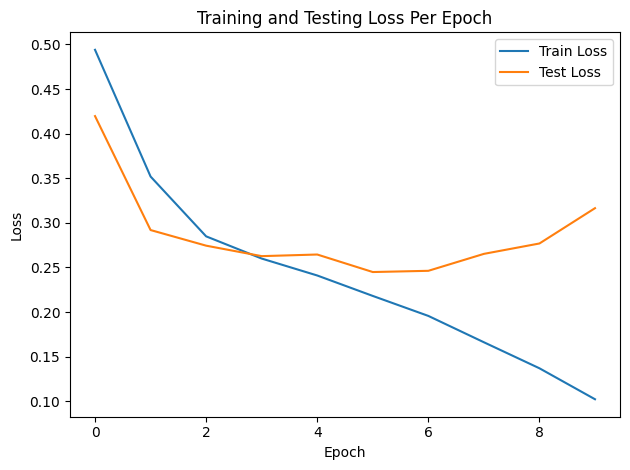

In [49]:
# Extract metrics
train_losses = metrics['train_loss']
test_losses = metrics['test_loss']
train_accuracies = metrics['train_accuracy']
test_accuracies = metrics['test_accuracy']

# Plotting training and testing losses
# plt.figure(figsize=(6, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Training and Testing Loss Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

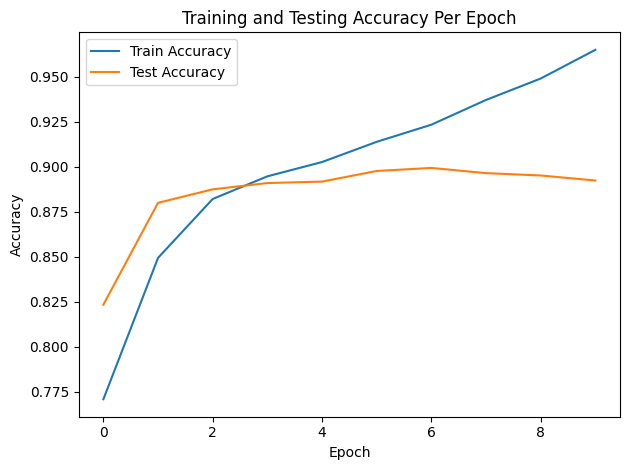

In [50]:
# Plotting training and testing accuracies
# plt.figure(figsize=(4, 4))
# plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Training and Testing Accuracy Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [63]:
def test_model(model, test_loader, criterion, device):
    model.eval()
    model.to(device)

    total_test_loss = 0
    total_test_correct = 0
    total_test = 0
    test_outputs_list = []
    test_labels_list = []

    with torch.inference_mode():
        for embeddings, labels in test_loader:
            embeddings, labels = embeddings.to(device), labels.to(device)
            outputs = model(embeddings).squeeze()
            loss = criterion(outputs, labels)
            total_test_loss += loss.item()

            predicted = (outputs > 0.5).float()
            test_outputs_list.append(predicted)
            test_labels_list.append(labels)

            total_test_correct += (predicted == labels).sum().item()
            total_test += labels.size(0)

    test_loss = total_test_loss / len(test_loader)
    test_accuracy = total_test_correct / total_test

    test_outputs = torch.cat(test_outputs_list)
    test_labels = torch.cat(test_labels_list)

    precision = precision_score(test_labels.cpu(), test_outputs.cpu())
    recall = recall_score(test_labels.cpu(), test_outputs.cpu())
    f1 = f1_score(test_labels.cpu(), test_outputs.cpu())

    cm = confusion_matrix(test_labels.cpu(), test_outputs.cpu())
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.title('Confusion Matrix for 50k data with 64 batch')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

    return test_loss, test_accuracy, precision, recall, f1


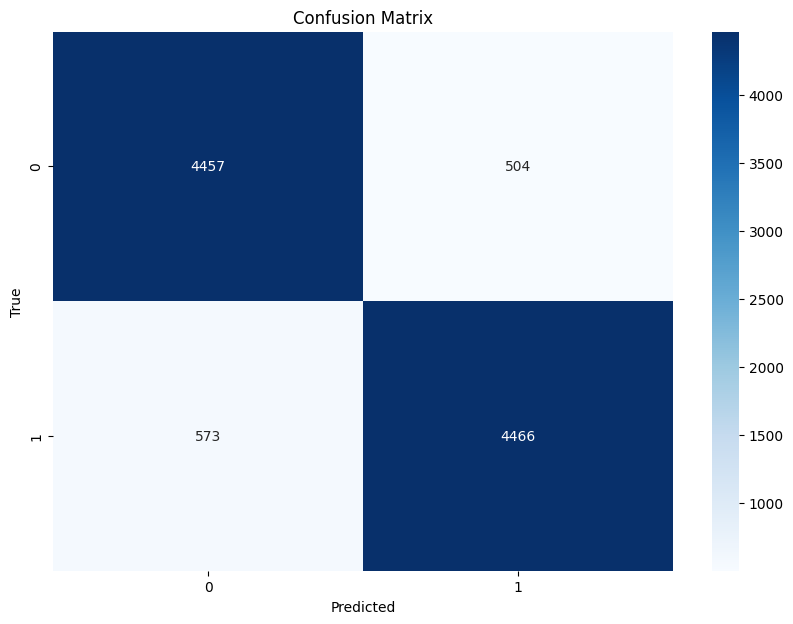

Test Loss: 0.31642890275473806
Test Accuracy: 0.8923
Precision: 0.8985915492957747
Recall: 0.8862869616987498
F1 Score: 0.8923968428414427


In [51]:
test_loss, test_accuracy, precision, recall, f1 = test_model(model, test_loader, criterion, device)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

#### VER.2 (50k data, 32 batch)

In [53]:
# Data preparation and loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)

In [55]:
def train_and_evaluate(model, train_loader, test_loader, optimizer, criterion, device, n_epochs):
    # Lists to store metrics
    metrics = {
        "train_loss": [],
        "test_loss": [],
        "train_accuracy": [],
        "test_accuracy": [],
        "precision": [],
        "recall": [],
        "f1_score": []
    }

    best_accuracy = 0
    best_epoch = 0
    final_outputs = None
    final_labels = None

    for epoch in range(n_epochs):
        start_time = time.time()

        # Training
        model.train()
        total_train_loss = 0
        total_train_correct = 0
        total_train = 0
        for embeddings, labels in train_loader:
            embeddings, labels = embeddings.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(embeddings).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            predicted = (outputs > 0.5).float()
            total_train_correct += (predicted == labels).sum().item()
            total_train += labels.size(0)

        train_loss = total_train_loss / len(train_loader)
        train_accuracy = total_train_correct / total_train

        # Testing
        model.eval()
        total_test_loss = 0
        total_test_correct = 0
        total_test = 0
        test_outputs_list = []
        test_labels_list = []
        with torch.no_grad():
            for embeddings, labels in test_loader:
                embeddings, labels = embeddings.to(device), labels.to(device)
                outputs = model(embeddings).squeeze()
                loss = criterion(outputs, labels)
                total_test_loss += loss.item()

                predicted = (outputs > 0.5).float()
                test_outputs_list.append(predicted)
                test_labels_list.append(labels)

                total_test_correct += (predicted == labels).sum().item()
                total_test += labels.size(0)

        test_loss = total_test_loss / len(test_loader)
        test_accuracy = total_test_correct / total_test

        # Calculate additional metrics
        test_outputs = torch.cat(test_outputs_list)
        test_labels = torch.cat(test_labels_list)
        precision = precision_score(test_labels.cpu(), test_outputs.cpu())
        recall = recall_score(test_labels.cpu(), test_outputs.cpu())
        f1 = f1_score(test_labels.cpu(), test_outputs.cpu())

        # Append to metrics dictionary
        metrics["train_loss"].append(train_loss)
        metrics["test_loss"].append(test_loss)
        metrics["train_accuracy"].append(train_accuracy)
        metrics["test_accuracy"].append(test_accuracy)
        metrics["precision"].append(precision)
        metrics["recall"].append(recall)
        metrics["f1_score"].append(f1)

        # Update best accuracy and store results for the best epoch
        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            best_epoch = epoch
            final_outputs = test_outputs
            final_labels = test_labels

        end_time = time.time()
        epoch_duration = end_time - start_time
        total_time = time.strftime("%H:%M:%S", time.gmtime(epoch_duration))

        print(f"Epoch {epoch+1}/{n_epochs}")
        print(f"Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")
        print(f"Testing Loss: {test_loss:.4f}, Testing Accuracy: {test_accuracy:.4f}")
        print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
        print(f"Duration: {total_time} (hh:mm:ss)")

    # Plot confusion matrix for the best epoch
    if best_epoch == epoch or best_accuracy == test_accuracy:  # Condition to check best or last epoch
        cm = confusion_matrix(final_labels.cpu(), final_outputs.cpu())
        plt.figure(figsize=(10, 7))
        sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title(f'Confusion Matrix at Epoch {best_epoch+1} with Best Accuracy')
        plt.savefig(f'confusion_matrix_epoch_{best_epoch+1}.png')
        plt.show()

    # Save all metrics to a JSON file
    with open('/content/drive/MyDrive/UNIVERSITAS TELKOM S2/SEMESTER 3/DAMIN/UTS/model/ver2-model_metrics-50kdata-32batch.json', 'w') as f:
        json.dump(metrics, f)

# Configuration and model setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BiLSTM(embedding_dim=100, hidden_dim=128, output_dim=1, num_layers=2).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.BCELoss()

In [56]:
# Run the training and evaluation with 64 BATCH
n_epochs = 10
train_and_evaluate(model, train_loader, test_loader, optimizer, criterion, device, n_epochs)

Epoch 1/10
Training Loss: 0.4517, Training Accuracy: 0.7962
Testing Loss: 0.3329, Testing Accuracy: 0.8520
Precision: 0.9011, Recall: 0.7934, F1 Score: 0.8438
Duration: 00:00:32 (hh:mm:ss)
Epoch 2/10
Training Loss: 0.3012, Training Accuracy: 0.8748
Testing Loss: 0.2724, Testing Accuracy: 0.8853
Precision: 0.8640, Recall: 0.9167, F1 Score: 0.8896
Duration: 00:00:33 (hh:mm:ss)
Epoch 3/10
Training Loss: 0.2685, Training Accuracy: 0.8903
Testing Loss: 0.2542, Testing Accuracy: 0.8954
Precision: 0.8846, Recall: 0.9113, F1 Score: 0.8978
Duration: 00:00:33 (hh:mm:ss)
Epoch 4/10
Training Loss: 0.2399, Training Accuracy: 0.9023
Testing Loss: 0.2526, Testing Accuracy: 0.8963
Precision: 0.8740, Recall: 0.9280, F1 Score: 0.9002
Duration: 00:00:33 (hh:mm:ss)
Epoch 5/10
Training Loss: 0.2118, Training Accuracy: 0.9170
Testing Loss: 0.2446, Testing Accuracy: 0.8984
Precision: 0.9016, Recall: 0.8962, F1 Score: 0.8989
Duration: 00:00:32 (hh:mm:ss)
Epoch 6/10
Training Loss: 0.1786, Training Accuracy: 0.

In [58]:
def load_metrics(file_path):
    with open(file_path, 'r') as file:
        metrics = json.load(file)
    return metrics

metrics = load_metrics('/content/drive/MyDrive/UNIVERSITAS TELKOM S2/SEMESTER 3/DAMIN/UTS/model/ver2-model_metrics-50kdata-32batch.json')

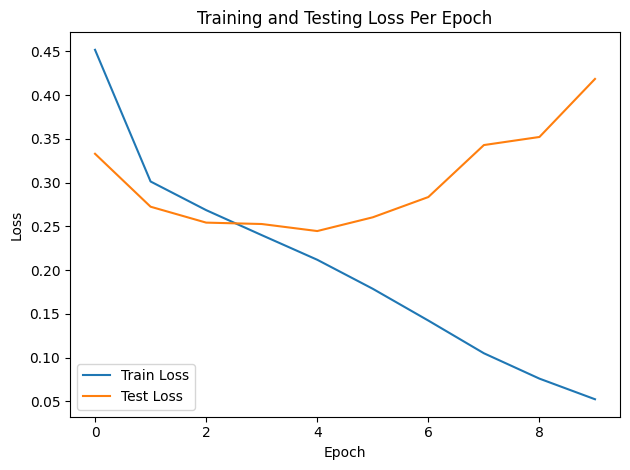

In [59]:
# Extract metrics
train_losses = metrics['train_loss']
test_losses = metrics['test_loss']
train_accuracies = metrics['train_accuracy']
test_accuracies = metrics['test_accuracy']

# Plotting training and testing losses
# plt.figure(figsize=(6, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Training and Testing Loss Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

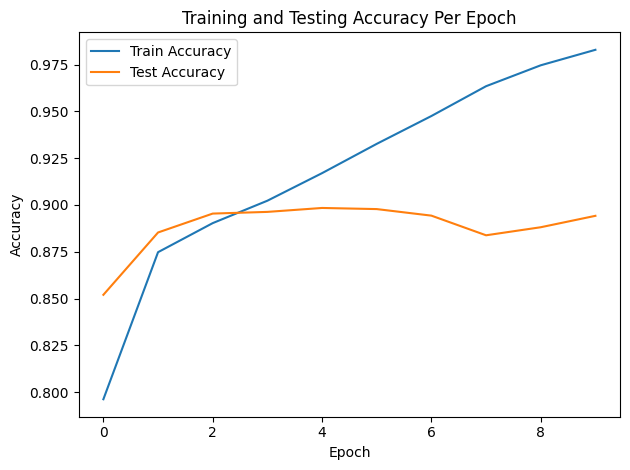

In [60]:
# Plotting training and testing accuracies
# plt.figure(figsize=(4, 4))
# plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Training and Testing Accuracy Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [64]:
def test_model(model, test_loader, criterion, device):
    model.eval()
    model.to(device)

    total_test_loss = 0
    total_test_correct = 0
    total_test = 0
    test_outputs_list = []
    test_labels_list = []

    with torch.inference_mode():
        for embeddings, labels in test_loader:
            embeddings, labels = embeddings.to(device), labels.to(device)
            outputs = model(embeddings).squeeze()
            loss = criterion(outputs, labels)
            total_test_loss += loss.item()

            predicted = (outputs > 0.5).float()
            test_outputs_list.append(predicted)
            test_labels_list.append(labels)

            total_test_correct += (predicted == labels).sum().item()
            total_test += labels.size(0)

    test_loss = total_test_loss / len(test_loader)
    test_accuracy = total_test_correct / total_test

    test_outputs = torch.cat(test_outputs_list)
    test_labels = torch.cat(test_labels_list)

    precision = precision_score(test_labels.cpu(), test_outputs.cpu())
    recall = recall_score(test_labels.cpu(), test_outputs.cpu())
    f1 = f1_score(test_labels.cpu(), test_outputs.cpu())

    cm = confusion_matrix(test_labels.cpu(), test_outputs.cpu())
    plt.figure(figsize=(10, 7))
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.title('Confusion Matrix for 50k data with 64 batch')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    plt.show()

    return test_loss, test_accuracy, precision, recall, f1


<Figure size 1000x700 with 0 Axes>

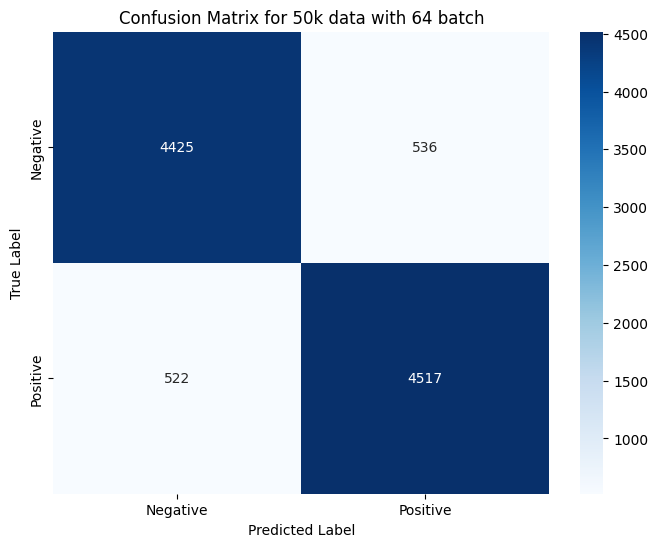

Test Loss: 0.4184557321829537
Test Accuracy: 0.8942
Precision: 0.8939244013457353
Recall: 0.8964080174637825
F1 Score: 0.8951644867221562


In [65]:
test_loss, test_accuracy, precision, recall, f1 = test_model(model, test_loader, criterion, device)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

#### VER.3 (TRIM DATA TO 20k)

In [ ]:
print("Original distribution:\n", df_lemmatization['sentiment'].value_counts())

Original distribution:
 sentiment
1    25000
0    25000
Name: count, dtype: int64


In [ ]:
df_lemmatization_trim = df_lemmatization.copy()

In [ ]:
# Desired number of samples per class
samples_per_class = 10000

# Count the number of samples for each class
positive_count = (df_lemmatization_trim['sentiment'] == 1).sum()
negative_count = (df_lemmatization_trim['sentiment'] == 0).sum()

print("Number of positive samples:", positive_count)
print("Number of negative samples:", negative_count)

# Sample from each class if there are enough samples
if positive_count >= samples_per_class and negative_count >= samples_per_class:
    trimmed_positive = df_lemmatization_trim[df_lemmatization_trim['sentiment'] == 1].sample(samples_per_class, random_state=42)
    trimmed_negative = df_lemmatization_trim[df_lemmatization_trim['sentiment'] == 0].sample(samples_per_class, random_state=42)

    # Concatenate the two subsets
    df_lemmatization_trim = pd.concat([trimmed_positive, trimmed_negative])

    # Shuffle the dataset to mix positive and negative reviews
    df_lemmatization_trim = df_lemmatization_trim.sample(frac=1, random_state=42).reset_index(drop=True)

    # Save the trimmed dataset if needed
    # df_lemmatization_trim.to_csv('Trimmed_IMDB_Dataset.csv', index=False)

    print("Trimmed distribution:\n", df_lemmatization_trim['sentiment'].value_counts())
else:
    print("Not enough samples for each class to perform sampling.")


Number of positive samples: 25000
Number of negative samples: 25000
Trimmed distribution:
 sentiment
0    10000
1    10000
Name: count, dtype: int64


In [ ]:
from gensim.models import Word2Vec

# Prepare data for Word2Vec
sentences_trim = [row.split() for row in df_lemmatization_trim['processed_review']]
word2vec_model = Word2Vec(sentences_trim, vector_size=100, window=5, min_count=2, workers=4)

# Save the model for later use
word2vec_model.save("/content/drive/MyDrive/UNIVERSITAS TELKOM S2/SEMESTER 3/DAMIN/UTS/model/word2vec_imdb_trim.model")

In [ ]:
# Split data into training and testing sets
train_sentences_trim, test_sentences_trim, train_labels_trim, test_labels_trim = train_test_split(sentences_trim, df_lemmatization_trim['sentiment'].values, test_size=0.2, random_state=42)

# Create Datasets
train_dataset_trim = IMDBDataset(train_sentences_trim, train_labels_trim, word2vec_model)
test_dataset_trim = IMDBDataset(test_sentences_trim , test_labels_trim, word2vec_model)

# Using the collate_fn in DataLoader
# Data preparation and loaders
train_loader_trim = DataLoader(train_dataset_trim, batch_size=256, shuffle=True, collate_fn=collate_fn)
test_loader_trim = DataLoader(test_dataset_trim, batch_size=256, shuffle=False, collate_fn=collate_fn)

In [ ]:
import time
import torch
import torch.optim as optim
from torch.utils.data import DataLoader

# Assuming BiLSTM, IMDBDataset, and collate_fn are already defined

def train_and_evaluate(model, train_loader, test_loader, optimizer, criterion, device, n_epochs):
    for epoch in range(n_epochs):
        start_time = time.time()

        # Training
        model.train()
        total_train_loss = 0
        total_train_correct = 0
        total_train = 0
        for embeddings, labels in train_loader:
            embeddings, labels = embeddings.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(embeddings).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            total_train_loss += loss.item()
            predicted = (outputs > 0.5).float()  # Using 0.5 as the threshold
            total_train_correct += (predicted == labels).sum().item()
            total_train += labels.size(0)
        train_loss = total_train_loss / len(train_loader)
        train_accuracy = total_train_correct / total_train

        # Testing
        model.eval()
        total_test_loss = 0
        total_test_correct = 0
        total_test = 0
        with torch.no_grad():
            for embeddings, labels in test_loader:
                embeddings, labels = embeddings.to(device), labels.to(device)
                outputs = model(embeddings).squeeze()
                loss = criterion(outputs, labels)
                total_test_loss += loss.item()
                predicted = (outputs > 0.5).float()  # Using 0.5 as the threshold
                total_test_correct += (predicted == labels).sum().item()
                total_test += labels.size(0)
        test_loss = total_test_loss / len(test_loader)
        test_accuracy = total_test_correct / total_test

        end_time = time.time()
        epoch_duration = end_time - start_time
        total_time = time.strftime("%H:%M:%S", time.gmtime(epoch_duration))

        print(f"Epoch {epoch+1}/{n_epochs}")
        print(f"Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")
        print(f"Testing Loss: {test_loss:.4f}, Testing Accuracy: {test_accuracy:.4f}")
        print(f"Duration: {total_time} (hh:mm:ss)")

# Configuration and model setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BiLSTM(embedding_dim=100, hidden_dim=128, output_dim=1, num_layers=2).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.BCELoss()

In [ ]:
# Run the training and evaluation
n_epochs = 10
train_and_evaluate(model, train_loader_trim, test_loader_trim, optimizer, criterion, device, n_epochs)

Epoch 1/10
Training Loss: 0.5994, Training Accuracy: 0.6768
Testing Loss: 0.5295, Testing Accuracy: 0.7375
Duration: 00:41:08 (hh:mm:ss)
Epoch 2/10
Training Loss: 0.5548, Training Accuracy: 0.7215
Testing Loss: 0.5341, Testing Accuracy: 0.7248
Duration: 00:22:56 (hh:mm:ss)
Epoch 3/10
Training Loss: 0.5186, Training Accuracy: 0.7560
Testing Loss: 0.4624, Testing Accuracy: 0.7937
Duration: 00:15:14 (hh:mm:ss)
Epoch 4/10
Training Loss: 0.4457, Training Accuracy: 0.8054
Testing Loss: 0.4420, Testing Accuracy: 0.8217
Duration: 00:17:17 (hh:mm:ss)
Epoch 5/10
Training Loss: 0.4518, Training Accuracy: 0.7982
Testing Loss: 0.4397, Testing Accuracy: 0.8055
Duration: 00:16:35 (hh:mm:ss)
Epoch 6/10
Training Loss: 0.5096, Training Accuracy: 0.7589
Testing Loss: 0.6501, Testing Accuracy: 0.6140
Duration: 00:18:32 (hh:mm:ss)
Epoch 7/10
Training Loss: 0.5131, Training Accuracy: 0.7449
Testing Loss: 0.4397, Testing Accuracy: 0.8050
Duration: 00:33:01 (hh:mm:ss)
Epoch 8/10
Training Loss: 0.4255, Trainin

In [ ]:
from sklearn.metrics import precision_recall_fscore_support

In [ ]:
def test(model, test_loader, criterion, device):
    model.eval()
    total_loss = 0
    total_correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for embeddings, labels in test_loader:
            embeddings, labels = embeddings.to(device), labels.to(device)
            outputs = model(embeddings).squeeze()
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            predicted = (outputs > 0.5).float()
            total_correct += (predicted == labels).sum().item()
            total += labels.size(0)
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())
    avg_loss = total_loss / len(test_loader)
    accuracy = total_correct / total
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_predictions, average='binary')
    return avg_loss, accuracy, precision, recall, f1, all_labels, all_predictions

# Example of calling the test function and printing results:
loss, accuracy, precision, recall, f1, labels, predictions = test(model, test_loader_trim, criterion, device)

Test Loss: 0.3668, Accuracy: 0.8475, Precision: 0.8666, Recall: 0.8311, F1 Score: 0.8485

Classification Report:
              precision    recall  f1-score   support

    Negative       0.83      0.86      0.85      1945
    Positive       0.87      0.83      0.85      2055

    accuracy                           0.85      4000
   macro avg       0.85      0.85      0.85      4000
weighted avg       0.85      0.85      0.85      4000



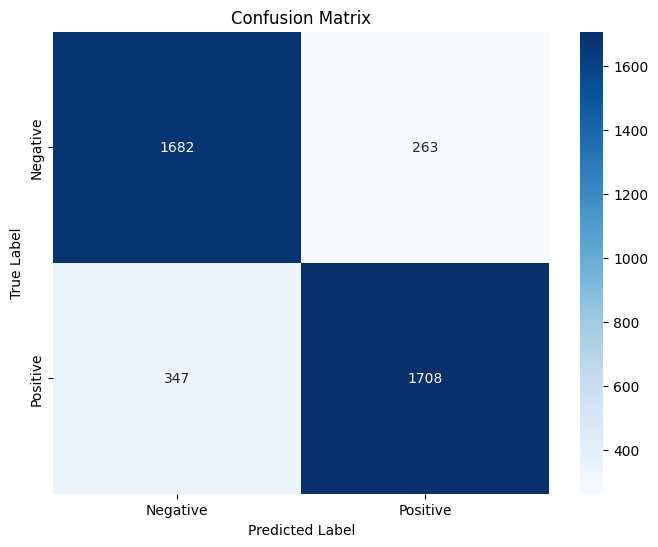

In [ ]:
print(f"Test Loss: {loss:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")

# Printing classification report
print("\nClassification Report:")
print(classification_report(labels, predictions, target_names=['Negative', 'Positive']))


# Plot confusion matrix
cm = confusion_matrix(labels, predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

#### VER.4 (DIFFERENT BILSTM ARCHITECTURE)

In [115]:
class IMDBDatasetv2(Dataset):
    def __init__(self, reviews, labels, token_to_idx):
        self.reviews = reviews
        self.labels = labels
        self.token_to_idx = token_to_idx
        self.unk_token_idx = token_to_idx['<UNK>']
        self.indices = [[self.token_to_idx.get(word, self.unk_token_idx) for word in review] for review in reviews]

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, idx):
        return torch.tensor(self.indices[idx], dtype=torch.long), torch.tensor(self.labels[idx], dtype=torch.float32)

def collate_fnv2(batch):
    sequences, labels = zip(*batch)
    sequences_padded = pad_sequence(sequences, batch_first=True, padding_value=0)  # Assume 0 is the pad index
    labels = torch.stack(labels)
    return sequences_padded, labels


class BiLSTMv2(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers, pretrained_embeddings):
        super(BiLSTMv2, self).__init__()
        self.embedding = nn.Embedding.from_pretrained(pretrained_embeddings, freeze=True)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True, bidirectional=True)
        self.dropout = nn.Dropout(p=0.5)
        self.attention = self.build_attention(hidden_dim * 2)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)

    def build_attention(self, input_dim):
        # This is a simple attention mechanism that just computes weights based on the input dimension and returns a weighted average.
        self.attention_weights = nn.Linear(input_dim, 1)

    def apply_attention(self, lstm_output, final_hidden):
        # Apply attention weights to the lstm outputs (hidden states)
        weights = F.softmax(self.attention_weights(lstm_output), dim=1)
        attended_hidden = torch.sum(weights * lstm_output, dim=1)
        return attended_hidden

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_output, (hidden, cell) = self.lstm(embedded)
        # Applying dropout to lstm outputs for regularization
        lstm_output = self.dropout(lstm_output)
        # Apply attention
        hidden_with_attention = self.apply_attention(lstm_output, hidden)
        out = self.fc(hidden_with_attention)
        return torch.sigmoid(out)

In [117]:
# Prepare the embedding matrix
vocab = {word: idx + 1 for idx, word in enumerate(word2vec_model.wv.index_to_key)}  # +1 to reserve 0 for padding
vocab['<UNK>'] = len(vocab) + 1
embedding_matrix = np.zeros((len(vocab) + 1, 100))  # Plus one for padding index

# Use the average of all vectors for <UNK>
average_vector = np.mean(word2vec_model.wv.vectors, axis=0)
embedding_matrix[vocab['<UNK>']] = average_vector

# Populate the embedding matrix
for word, idx in vocab.items():
    if word in word2vec_model.wv:
        embedding_matrix[idx] = word2vec_model.wv[word]
    elif word == '<UNK>':  # Ensure <UNK> is not overwritten accidentally
        continue  # <UNK> is already set to the average vector

# Ensure the type is appropriate for PyTorch
embedding_matrix = embedding_matrix.astype(np.float32)


In [118]:
# Data preparation
sentences = [row.split() for row in df_lemmatization['processed_review']]
train_sentences, test_sentences, train_labels, test_labels = train_test_split(sentences, df_lemmatization['sentiment'].values, test_size=0.2, random_state=42)
train_dataset = IMDBDatasetv2(train_sentences, train_labels, vocab)
test_dataset = IMDBDatasetv2(test_sentences, test_labels, vocab)

train_loaderv2 = DataLoader(train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fnv2)
test_loaderv2 = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fnv2)

In [119]:
def train_and_evaluate_v2(model, train_loader, test_loader, optimizer, criterion, device, n_epochs):
    # Lists to store metrics
    metrics = {
        "train_loss": [],
        "test_loss": [],
        "train_accuracy": [],
        "test_accuracy": [],
        "precision": [],
        "recall": [],
        "f1_score": []
    }

    best_accuracy = 0
    best_epoch = 0
    final_outputs = None
    final_labels = None

    for epoch in range(n_epochs):
        start_time = time.time()

        # Training
        model.train()
        total_train_loss = 0
        total_train_correct = 0
        total_train = 0
        for embeddings, labels in train_loader:
            embeddings, labels = embeddings.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(embeddings).squeeze()
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_train_loss += loss.item()
            predicted = (outputs > 0.5).float()
            total_train_correct += (predicted == labels).sum().item()
            total_train += labels.size(0)

        train_loss = total_train_loss / len(train_loader)
        train_accuracy = total_train_correct / total_train

        # Testing
        model.eval()
        total_test_loss = 0
        total_test_correct = 0
        total_test = 0
        test_outputs_list = []
        test_labels_list = []
        with torch.no_grad():
            for embeddings, labels in test_loader:
                embeddings, labels = embeddings.to(device), labels.to(device)
                outputs = model(embeddings).squeeze()
                loss = criterion(outputs, labels)
                total_test_loss += loss.item()

                predicted = (outputs > 0.5).float()
                test_outputs_list.append(predicted)
                test_labels_list.append(labels)

                total_test_correct += (predicted == labels).sum().item()
                total_test += labels.size(0)

        test_loss = total_test_loss / len(test_loader)
        test_accuracy = total_test_correct / total_test

        # Calculate additional metrics
        test_outputs = torch.cat(test_outputs_list)
        test_labels = torch.cat(test_labels_list)
        precision = precision_score(test_labels.cpu(), test_outputs.cpu())
        recall = recall_score(test_labels.cpu(), test_outputs.cpu())
        f1 = f1_score(test_labels.cpu(), test_outputs.cpu())

        # Append to metrics dictionary
        metrics["train_loss"].append(train_loss)
        metrics["test_loss"].append(test_loss)
        metrics["train_accuracy"].append(train_accuracy)
        metrics["test_accuracy"].append(test_accuracy)
        metrics["precision"].append(precision)
        metrics["recall"].append(recall)
        metrics["f1_score"].append(f1)

        # Update best accuracy and store results for the best epoch
        if test_accuracy > best_accuracy:
            best_accuracy = test_accuracy
            best_epoch = epoch
            final_outputs = test_outputs
            final_labels = test_labels

        end_time = time.time()
        epoch_duration = end_time - start_time
        total_time = time.strftime("%H:%M:%S", time.gmtime(epoch_duration))

        print(f"Epoch {epoch+1}/{n_epochs}")
        print(f"Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")
        print(f"Testing Loss: {test_loss:.4f}, Testing Accuracy: {test_accuracy:.4f}")
        print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
        print(f"Duration: {total_time} (hh:mm:ss)")

    # Plot confusion matrix for the best epoch
    if best_epoch == epoch or best_accuracy == test_accuracy:  # Condition to check best or last epoch
        cm = confusion_matrix(final_labels.cpu(), final_outputs.cpu())
        plt.figure(figsize=(10, 7))
        sns.heatmap(cm, annot=True, fmt='g', cmap='Blues')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title(f'Confusion Matrix at Epoch {best_epoch+1} with Best Accuracy')
        plt.savefig(f'confusion_matrix_epoch_{best_epoch+1}.png')
        plt.show()

    # Save all metrics to a JSON file
    with open('/content/drive/MyDrive/UNIVERSITAS TELKOM S2/SEMESTER 3/DAMIN/UTS/model/ver4-model_metrics-50kdata-32batch.json', 'w') as f:
        json.dump(metrics, f)

# Configuration and model setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Optimizer & Criterion
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.BCELoss()

import torch
import numpy as np

# Assuming you've already populated the embedding_matrix as you described
embedding_matrix = torch.from_numpy(embedding_matrix)

# Now embedding_matrix is a torch tensor, which you can pass to your model directly
modelv2 = BiLSTM(vocab_size=len(vocab) + 1, embedding_dim=100, hidden_dim=128, output_dim=1, num_layers=2, pretrained_embeddings=embedding_matrix).to(device)

Epoch 1/10
Training Loss: 0.6929, Training Accuracy: 0.5026
Testing Loss: 0.6928, Testing Accuracy: 0.5082
Precision: 0.5061, Recall: 0.9984, F1 Score: 0.6717
Duration: 00:00:17 (hh:mm:ss)
Epoch 2/10
Training Loss: 0.6929, Training Accuracy: 0.5024
Testing Loss: 0.6928, Testing Accuracy: 0.5082
Precision: 0.5061, Recall: 0.9984, F1 Score: 0.6717
Duration: 00:00:17 (hh:mm:ss)
Epoch 3/10
Training Loss: 0.6929, Training Accuracy: 0.5023
Testing Loss: 0.6928, Testing Accuracy: 0.5082
Precision: 0.5061, Recall: 0.9984, F1 Score: 0.6717
Duration: 00:00:17 (hh:mm:ss)
Epoch 4/10
Training Loss: 0.6929, Training Accuracy: 0.5021
Testing Loss: 0.6928, Testing Accuracy: 0.5082
Precision: 0.5061, Recall: 0.9984, F1 Score: 0.6717
Duration: 00:00:17 (hh:mm:ss)
Epoch 5/10
Training Loss: 0.6929, Training Accuracy: 0.5024
Testing Loss: 0.6928, Testing Accuracy: 0.5082
Precision: 0.5061, Recall: 0.9984, F1 Score: 0.6717
Duration: 00:00:17 (hh:mm:ss)
Epoch 6/10
Training Loss: 0.6929, Training Accuracy: 0.

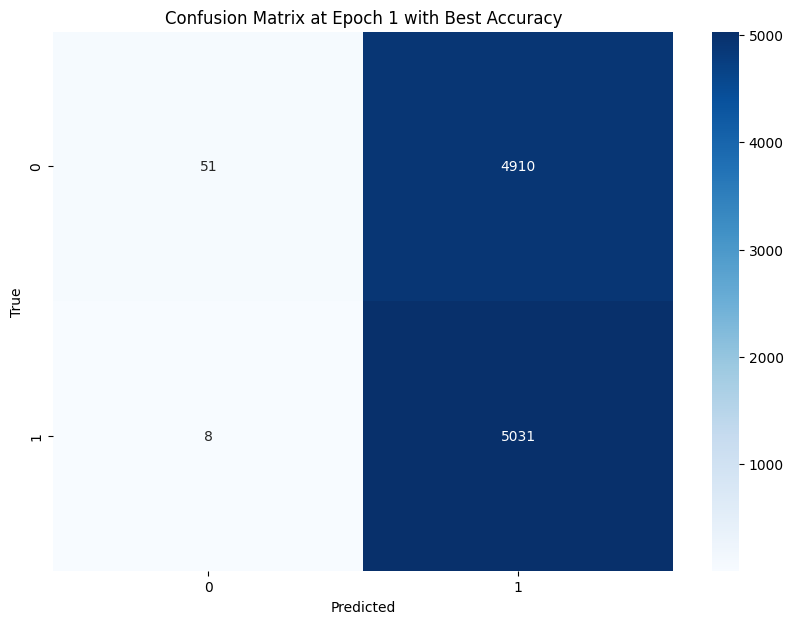

In [122]:
# Run the training and evaluation
n_epochs = 10
train_and_evaluate_v2(modelv2, train_loaderv2, test_loaderv2, optimizer, criterion, device, n_epochs)

In [123]:
def load_metrics(file_path):
    with open(file_path, 'r') as file:
        metrics = json.load(file)
    return metrics

metrics = load_metrics('/content/drive/MyDrive/UNIVERSITAS TELKOM S2/SEMESTER 3/DAMIN/UTS/model/ver4-model_metrics-50kdata-32batch.json')

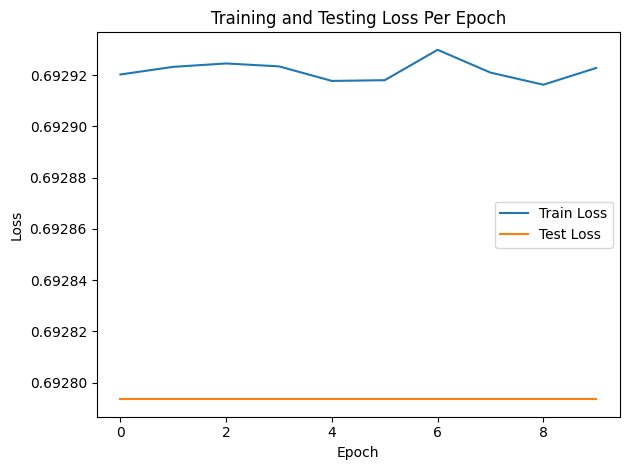

In [124]:
# Extract metrics
train_losses = metrics['train_loss']
test_losses = metrics['test_loss']
train_accuracies = metrics['train_accuracy']
test_accuracies = metrics['test_accuracy']

# Plotting training and testing losses
# plt.figure(figsize=(6, 6))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Training and Testing Loss Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

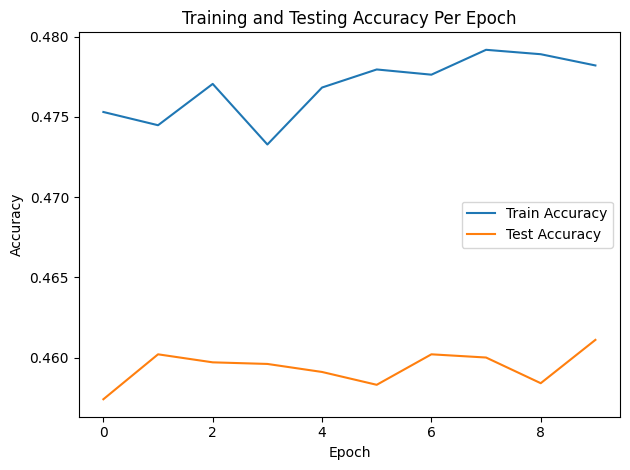

In [110]:
# Plotting training and testing accuracies
# plt.figure(figsize=(4, 4))
# plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Training and Testing Accuracy Per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

In [111]:
def test_model(model, test_loader, criterion, device):
    model.eval()
    model.to(device)

    total_test_loss = 0
    total_test_correct = 0
    total_test = 0
    test_outputs_list = []
    test_labels_list = []

    with torch.inference_mode():
        for embeddings, labels in test_loader:
            embeddings, labels = embeddings.to(device), labels.to(device)
            outputs = model(embeddings).squeeze()
            loss = criterion(outputs, labels)
            total_test_loss += loss.item()

            predicted = (outputs > 0.5).float()
            test_outputs_list.append(predicted)
            test_labels_list.append(labels)

            total_test_correct += (predicted == labels).sum().item()
            total_test += labels.size(0)

    test_loss = total_test_loss / len(test_loader)
    test_accuracy = total_test_correct / total_test

    test_outputs = torch.cat(test_outputs_list)
    test_labels = torch.cat(test_labels_list)

    precision = precision_score(test_labels.cpu(), test_outputs.cpu())
    recall = recall_score(test_labels.cpu(), test_outputs.cpu())
    f1 = f1_score(test_labels.cpu(), test_outputs.cpu())

    cm = confusion_matrix(test_labels.cpu(), test_outputs.cpu())
    plt.figure(figsize=(10, 7))
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.title('Confusion Matrix for 50k data with 64 batch')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()
    plt.show()

    return test_loss, test_accuracy, precision, recall, f1


<Figure size 1000x700 with 0 Axes>

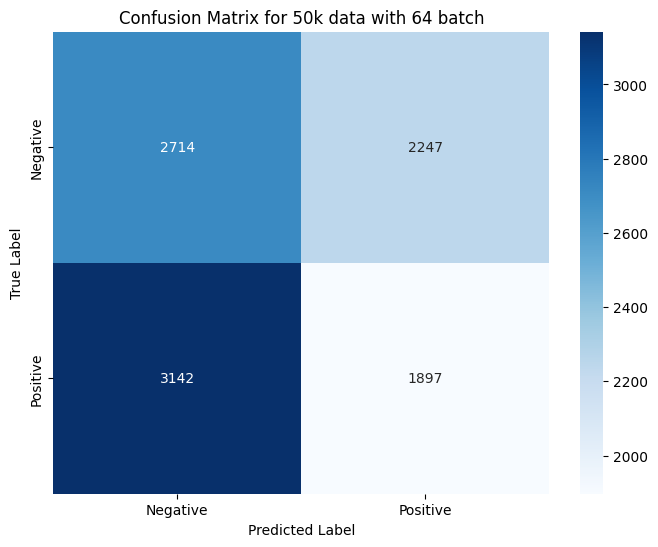

Test Loss: 0.7488588389878075
Test Accuracy: 0.4611
Precision: 0.4577702702702703
Recall: 0.3764635840444533
F1 Score: 0.41315474245889144


In [112]:
test_loss, test_accuracy, precision, recall, f1 = test_model(modelv2, test_loaderv2, criterion, device)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)